# Фаза 2 • Неделя 2 • Понедельник
## Компьютерное зрение
### Локализация объектов

In [161]:
# %pip install --upgrade pip
# %pip install numpy

In [162]:
# pip install torch==2.8.0
# %pip install torchutils
# %pip install mlflow
# %pip install torchvision torchmetrics
# %pip install opencv-python
# %pip install tqdm
# %pip install torch
# %pip uninstall torch torchvision torchaudio -y
# %pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [163]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional.detection.iou import intersection_over_union

from PIL import Image, ImageOps
from src.mnist_localization import get_dataloaders

import multiprocessing as mp

import mlflow

from tqdm.auto import tqdm

In [165]:
# Установите метод запуска процессов на 'spawn'
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)

torch.set_default_device("cuda")
# config = {
#     "batch_size": 2048,
#     "learning_rate": 0.002,
#     "epochs": 10,
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
#     "data_dir": "data/",
#     "log_dir": "runs/experiment1",
# }
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GENERATOR = torch.Generator(device=DEVICE)
BATCH_SIZE = 128
use_mlflow = True
mlflow.set_tracking_uri("http://localhost:5000")

plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [166]:
# данные для этой задачи сгенерируем автоматически с помощью фунцкии
train_loader, valid_loader = get_dataloaders(GENERATOR, BATCH_SIZE)

In [167]:
# Заберем один батч и проверим размеры данных: картинки, таргета и координат боксов
pic, label, true_box = next(iter(train_loader))
print(pic.shape, label.shape, true_box.shape)

torch.Size([128, 1, 100, 100]) torch.Size([128, 1]) torch.Size([128, 4])


In [168]:
def get_num_classes(loader, return_classes=False):
    """
    Универсально определяет количество классов в DataLoader.
    Работает даже если датасет возвращает не только (x, y), но и дополнительные данные.
    """
    dataset = loader.dataset

    # 1️⃣ Быстрый путь: если есть атрибут classes (например, ImageFolder)
    if hasattr(dataset, "classes"):
        classes = dataset.classes
        return (len(classes), classes) if return_classes else len(classes)

    # 2️⃣ Если есть targets (часто это список меток)
    if hasattr(dataset, "targets"):
        labels = torch.as_tensor(dataset.targets)
        unique_classes = labels.unique(sorted=True)
        return (
            (unique_classes.numel(), unique_classes.tolist())
            if return_classes
            else unique_classes.numel()
        )

    # 3️⃣ Универсальный путь: проходим по loader
    all_labels = []
    for batch in loader:
        # batch может быть tuple, list, dict
        if isinstance(batch, (tuple, list)):
            # предполагаем, что метки в batch[1]
            targets = batch[1]
        elif isinstance(batch, dict):
            # пытаемся найти ключ 'label' или 'target'
            if "label" in batch:
                targets = batch["label"]
            elif "target" in batch:
                targets = batch["target"]
            else:
                raise ValueError(
                    "Не могу найти метки в batch (нет ключа 'label' или 'target')"
                )
        else:
            raise ValueError(f"Неизвестный формат batch: {type(batch)}")

        targets = torch.as_tensor(targets)
        all_labels.append(targets)

    all_labels = torch.cat(all_labels)
    unique_classes = all_labels.unique(sorted=True)

    return (
        (unique_classes.numel(), unique_classes.tolist())
        if return_classes
        else unique_classes.numel()
    )


# 🔧 Пример использования:
num_classes = get_num_classes(train_loader, return_classes=False)
print(f"Количество классов: {num_classes}")

Количество классов: 10


In [169]:
# запишем в переменную размер картинки
IMG_SIZE = pic.shape[-1]
pic.shape

torch.Size([128, 1, 100, 100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[]

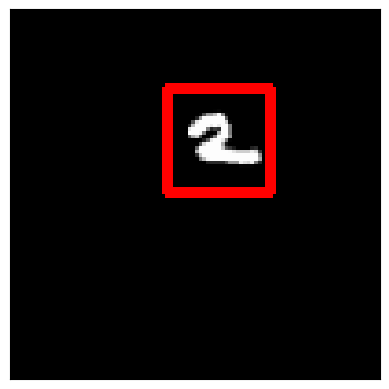

In [170]:
# Создаем область отрисовки картинки
fig, ax = plt.subplots(1, 1, squeeze=True)
# выбираем номер объекта из батча
k = 30
assert k < train_loader.batch_size, f"Batch size is 32, but k={k}"
# выбираем картинку и преобразовываем в numpy array
img = pic[k][0].cpu().numpy()
# конвертируем в cv2 – она умеет рисовать поверх
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# создаем прямоугольник
pic_label = cv2.rectangle(
    img,
    (
        (true_box[k][:2] * IMG_SIZE).numpy().astype("int")
    ),  # координаты левого верхнего угла рамки
    (
        (true_box[k][2:] * IMG_SIZE).numpy().astype("int")
    ),  # координаты правого нижнего угла рамки
    color=(255, 0, 0),
    thickness=2,  # красный цвет, толщина 2
)
ax.imshow(pic_label)  # рисуем все вместе
ax.set_xticks([])
ax.set_yticks([])  # убираем тики

In [171]:
# conv = nn.Sequential(
#     nn.Conv2d(1, 16, 5, stride=2),  # 48
#     nn.GELU(),
#     nn.MaxPool2d(2, 2),  # 24
#     nn.Conv2d(16, 8, 5, stride=2),  # 10
#     nn.GELU(),
#     nn.Conv2d(8, 4, 5),  # 6 x 6 x 4
#     nn.GELU(),
# )
conv = nn.Sequential(
    nn.Conv2d(1, 16, 2, padding=1, stride=1),  # 51
    nn.GELU(),
    nn.MaxPool2d(2, 2),  # 25
    nn.Conv2d(16, 8, 2, padding=1, stride=1),  # 13
    nn.GELU(),
    nn.Conv2d(8, 4, 2, padding=1),  # 14
    nn.GELU(),
)
out = conv(pic.cuda())
print(out.shape)  # torch.Size()
n_features = out[1:3].numel()  # общее число элементов
# n_features_per_sample = out.view(1, -1).size(1)
print(n_features, 4 * 6 * 6)  # это нужно подать в Linear
n_features = 4 * 52 * 52

torch.Size([128, 4, 52, 52])
21632 144


In [172]:
class LocalizationModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # backbone
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 2, padding=1, stride=1),  # 51
            nn.GELU(),
            nn.MaxPool2d(2, 2),  # 25
            nn.Conv2d(16, 8, 2, padding=1, stride=1),  # 13
            nn.GELU(),
            nn.Conv2d(8, 4, 2, padding=1),  # 14
            nn.GELU(),
        )

        # classification head: n_outputs = n_classes
        self.clf_head = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.GELU(),
            # nn.BatchNorm1d(128),
            # nn.Dropout(p=0.5),
            # nn.Linear(128, 64),
            # nn.GELU(),
            # nn.BatchNorm1d(64),
            # nn.Linear(128, 32),
            # nn.GELU(),
            # nn.BatchNorm1d(32),
            # nn.Dropout(p=0.2),
            nn.Linear(64, 10),
        )
        self.flat = nn.Flatten()
        # box regression head: n_outputs = n_coords (4)
        self.box_head = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.GELU(),
            # nn.BatchNorm1d(128),
            # nn.Linear(128, 64),
            # nn.GELU(),
            # # nn.BatchNorm1d(64),
            # nn.Linear(64, 32),
            # nn.GELU(),
            # nn.BatchNorm1d(32),
            # nn.Dropout(p=0.2),
            nn.Linear(64, 4),
        )

    def forward(self, pic: torch.Tensor):
        pic = self.backbone(pic)
        clf_out = self.clf_head(self.flat(pic))
        box_out = self.box_head(self.flat(pic))
        return clf_out, torch.sigmoid(box_out)


model = LocalizationModel()
model.to(DEVICE)

LocalizationModel(
  (backbone): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): GELU(approximate='none')
    (5): Conv2d(8, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (6): GELU(approximate='none')
  )
  (clf_head): Sequential(
    (0): Linear(in_features=10816, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (box_head): Sequential(
    (0): Linear(in_features=10816, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [173]:
with torch.no_grad():
    dummy_input = torch.randn(1, 1, 100, 100).to(DEVICE)
    dummy_output = model.backbone(dummy_input)
    n_features_per_sample = dummy_output.view(1, -1).size(1)

print(n_features_per_sample)

10816


In [174]:
lr = 1e-3
# optimizer = optim.SGD(
#     model.parameters(), lr=lr, nesterov=True, momentum=0.8, weight_decay=1e-4
# )
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-5)

In [175]:
# # Создаем область отрисовки картинки
# fig, ax = plt.subplots(1, 1, squeeze=True)
# # ax.title(f'Epoch {epoch}, True label: {temp_label}, Pred label: {temp_clf_pred}')
# # assert k < valid_loader.batch_size, f"Batch size is {BATCH_SIZE}, but k={k}"
# # выбираем картинку и преобразовываем в numpy array
# # img = batch[k][0].cpu().numpy()
# # конвертируем в cv2 – она умеет рисовать поверх
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# # создаем прямоугольник
# pic_true_label = cv2.rectangle(
#     img,
#     (
#         (temp_box[k][:2] * IMG_SIZE).numpy().astype("int")
#     ),  # координаты левого верхнего угла рамки
#     (
#         (temp_box[k][2:] * IMG_SIZE).numpy().astype("int")
#     ),  # координаты правого нижнего угла рамки
#     color=(0, 255, 0),
#     thickness=2,  # зеленый цвет, толщина 2
# )
# pic_pred_label = cv2.rectangle(
#     img,
#     (
#         (temp_box_pred[k][:2] * IMG_SIZE).numpy().astype("int")
#     ),  # координаты левого верхнего угла рамки
#     (
#         (temp_box_pred[k][2:] * IMG_SIZE).numpy().astype("int")
#     ),  # координаты правого нижнего угла рамки
#     color=(255, 0, 0),
#     thickness=1,  # красный цвет, толщина 1
# )
# ax.imshow(pic_true_label, pic_pred_label)  # рисуем все вместе
# ax.set_xticks([])
# ax.set_yticks([])  # убираем тики

In [176]:
def fit_model(
    epochs: int,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.modules.loss.CrossEntropyLoss = torch.nn.modules.loss.CrossEntropyLoss(),
    train_loader=train_loader,
    valid_loader=valid_loader,
) -> dict:
    log = dict()
    log["epoch_train_clf_loss"] = []
    log["epoch_valid_clf_loss"] = []
    log["epoch_train_box_loss"] = []
    log["epoch_valid_box_loss"] = []
    log["epoch_train_total_loss"] = []
    log["epoch_valid_total_loss"] = []
    log["epoch_train_accuracy"] = []
    log["epoch_valid_accuracy"] = []
    log["epoch_train_iou"] = []
    log["epoch_valid_iou"] = []

    start_epoch = len(log["epoch_train_clf_loss"])

    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        ### Обучение

        batch_clf_loss = []
        batch_reg_loss = []
        batch_acc = []
        batch_iou = []
        batch_total_loss = []

        model.train()

        # Прогресс бар

        train_pbar = tqdm(
            train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=True
        )

        for images, labels, boxes in train_pbar:

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            boxes = boxes.to(DEVICE)
            logits = model(images)[0]
            coords = model(images)[1]

            # Функции потерь

            loss_clf = F.cross_entropy(logits, labels.squeeze().long())
            loss_box = F.smooth_l1_loss(boxes, coords, reduction="sum", beta=1)

            # Метрики

            iou = intersection_over_union(coords, boxes)
            accuracy = (logits.argmax(1) == labels.squeeze()).sum() / labels.size(0)
            batch_acc.append(accuracy.item())
            batch_iou.append(iou.item())

            total_loss = loss_clf * (1 / (accuracy.item() + 1e-2)) + loss_box * (
                1 / (iou.item() + 1e-1)
            )
            # total_loss = loss_clf + loss_box
            total_loss.backward()
            optimizer.step()

            optimizer.zero_grad()

            batch_reg_loss.append(loss_box.item())
            batch_clf_loss.append(loss_clf.item())
            batch_total_loss.append(total_loss.item())
            train_pbar.set_postfix({"Loss": total_loss.item()})

        log["epoch_train_clf_loss"].append(np.mean(batch_clf_loss))
        log["epoch_train_box_loss"].append(np.mean(batch_reg_loss))
        log["epoch_train_total_loss"].append(np.mean(batch_total_loss))
        log["epoch_train_accuracy"].append(np.mean(batch_acc))
        log["epoch_train_iou"].append(np.mean(batch_iou))

        batch_clf_loss = []
        batch_reg_loss = []
        batch_acc = []
        batch_iou = []
        batch_total_loss = []

        model.eval()

        ### Валидация
        valid_pbar = tqdm(
            valid_loader, desc=f"Epoch {epoch}/{epochs} [Test]", leave=True
        )
        for images, labels, boxes in valid_pbar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            boxes = boxes.to(DEVICE)
            with torch.no_grad():
                clf_pred = model(images)[0]
                boxes_pred = model(images)[1]

            loss_clf = F.cross_entropy(clf_pred, labels.squeeze().long())
            loss_box = F.smooth_l1_loss(boxes_pred, boxes, reduction="sum", beta=1)
            total_loss = loss_clf * (1 / (accuracy.item() + 1e-2)) + loss_box * (
                1 / (iou.item() + 1e-2)
            )
            # total_loss = loss_clf + loss_box
            iou = intersection_over_union(boxes_pred, boxes)
            accuracy = (clf_pred.argmax(1) == labels.squeeze()).sum() / labels.size(0)

            batch_acc.append(accuracy.item())
            batch_iou.append(iou.item())
            batch_reg_loss.append(loss_box.item())
            batch_clf_loss.append(loss_clf.item())
            batch_total_loss.append(total_loss.item())
            valid_pbar.set_postfix({"Loss": total_loss.item()})

        log["epoch_valid_clf_loss"].append(np.mean(batch_clf_loss))
        log["epoch_valid_box_loss"].append(np.mean(batch_reg_loss))
        log["epoch_valid_total_loss"].append(np.mean(batch_total_loss))
        log["epoch_valid_accuracy"].append(np.mean(batch_acc))
        log["epoch_valid_iou"].append(np.mean(batch_iou))

        ### Метрики и отрисовка

        # [MLflow] Логируем метрики
        if use_mlflow:
            # epoch – номер шага (можно указывать step=epoch)
            for c in log.keys():
                mlflow.log_metric(c[6:], log[c][-1], step=epoch)
            # mlflow.log_metric("train_loss", log["train_losses"][-1], step=epoch)
            # mlflow.log_metric("train_acc", log["train_accs"][-1], step=epoch)
            # mlflow.log_metric("train_prec", log["train_precs"][-1], step=epoch)
            # mlflow.log_metric("train_recal", log["train_recals"][-1], step=epoch)
            # mlflow.log_metric("train_f1", log["train_f1s"][-1], step=epoch)
            # mlflow.log_metric("valid_loss", log["valid_losses"][-1], step=epoch)
            # mlflow.log_metric("valid_acc", log["valid_accs"][-1], step=epoch)
            # mlflow.log_metric("valid_prec", log["valid_precs"][-1], step=epoch)
            # mlflow.log_metric("valid_recal", log["valid_recals"][-1], step=epoch)
            # mlflow.log_metric("valid_f1", log["valid_f1s"][-1], step=epoch)

        # Train stage
        print(
            f"Train stage: "
            f"clf_loss: {log['epoch_train_clf_loss'][-1]:>6.3f}  "
            f"reg_loss: {log['epoch_train_box_loss'][-1]:>6.3f}  "
            f"total_loss: {log['epoch_train_total_loss'][-1]:>6.3f}  "
            f"accuracy: {log['epoch_train_accuracy'][-1]:>6.3f}  "
            f"iou: {log['epoch_train_iou'][-1]:>6.3f}"
        )

        # Valid stage
        print(
            f"Valid stage: "
            f"clf_loss: {log['epoch_valid_clf_loss'][-1]:>6.3f}  "
            f"reg_loss: {log['epoch_valid_box_loss'][-1]:>6.3f}  "
            f"total_loss: {log['epoch_valid_total_loss'][-1]:>6.3f}  "
            f"accuracy: {log['epoch_valid_accuracy'][-1]:>6.3f}  "
            f"iou: {log['epoch_valid_iou'][-1]:>6.3f}"
        )

        print(f'{"-"*35}\n')
        num_batches = len(valid_loader)

        # выбираем случайный индекс батча и случайный номер внутри батча
        random_idx = torch.randint(0, num_batches, (1,)).item()

        # проходим по loader и берем нужный батч
        for i, batch in enumerate(valid_loader):
            if i == random_idx:
                images_batch, labels_batch, boxes_batch = batch
                k = torch.randint(0, images_batch.size(0), (1,)).item()
                temp_image = (
                    images_batch[k].unsqueeze(0).to(DEVICE)
                )  # добавляем batch_dim
                temp_label = labels_batch[k]
                temp_box = boxes_batch[k]
                break
        with torch.no_grad():
            temp_clf_pred = model(temp_image)[0]
            temp_box_pred = model(temp_image)[1]

        # Создаем область отрисовки картинки
        fig, ax = plt.subplots(1, 1, squeeze=True)
        # assert k < valid_loader.batch_size, f"Batch size is {BATCH_SIZE}, but k={k}"
        # выбираем картинку и преобразовываем в numpy array
        # img = batch[k][0].cpu().numpy()
        # конвертируем в cv2 – она умеет рисовать поверх
        true_box_coords = (temp_box * IMG_SIZE).cpu().numpy().astype(int)
        pred_box_coords = (temp_box_pred[0] * IMG_SIZE).cpu().numpy().astype(int)

        # изображение для рисования
        img = temp_image[0].cpu().numpy().transpose(1, 2, 0)  # (H,W,C)

        # OpenCV требует uint8
        img = (img * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # рисуем прямоугольники
        cv2.rectangle(
            img, tuple(true_box_coords[:2]), tuple(true_box_coords[2:]), (0, 255, 0), 2
        )
        cv2.rectangle(
            img, tuple(pred_box_coords[:2]), tuple(pred_box_coords[2:]), (255, 0, 0), 1
        )

        plt.imshow(img)
        plt.title(
            f"Epoch {epoch}, True label: {int(temp_label.item())}, Pred label: {temp_clf_pred.argmax(1).item()}"
        )
        plt.axis("off")
        plt.show()
        ax.set_xticks([])
        ax.set_yticks([])  # убираем тики

    return log

    #######################
    # блок визуализации результатов
    # доработай его так, чтобы после каждой эпохи распечатывалась картинка
    # с оригинальным боксом и предсказанным боксом (пример ниже)
    #######################

In [177]:
def fit_with_mlflow(
    model=model,
    epochs=15,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
    augmentation=True,
    experiment_name="Localization",
):
    mlflow.set_experiment(experiment_name)  # установить (или создать) эксперимент
    with mlflow.start_run(run_name=f"convnext_tiny_bs_{BATCH_SIZE}_lr_{lr}"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("device", DEVICE)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("augmentation", ("Yes" if augmentation else "No"))

        # Запускаем обучение
        logs = fit_model(
            model=model,
            epochs=epochs,
            optimizer=optimizer,
            train_loader=train_loader,
            valid_loader=valid_loader,
        )

        # Сохраняем модель в MLflow (опционально)
        # mlflow.pytorch.log_model(base_cnn, "model")

    # После выхода из `with` Run автоматически завершается
    return logs

------------- Epoch 1 -------------


Epoch 1/30 [Test]: 100%|██████████| 79/79 [00:02<00:00, 32.61it/s, Loss=7.1] 


Train stage: clf_loss:  2.148  reg_loss:  1.699  total_loss: 19.012  accuracy:  0.207  iou:  0.671
Valid stage: clf_loss:  1.954  reg_loss:  0.071  total_loss:  7.125  accuracy:  0.281  iou:  0.854
-----------------------------------



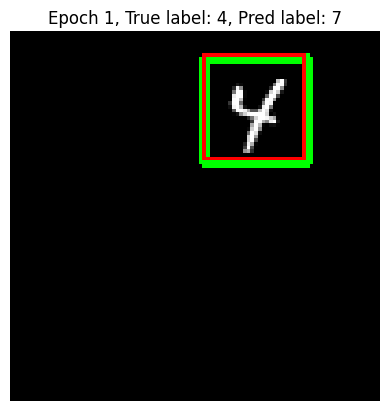

------------- Epoch 2 -------------


Epoch 2/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 102.83it/s, Loss=4.54]


Train stage: clf_loss:  1.836  reg_loss:  0.053  total_loss:  5.533  accuracy:  0.337  iou:  0.865
Valid stage: clf_loss:  1.671  reg_loss:  0.035  total_loss:  4.122  accuracy:  0.411  iou:  0.884
-----------------------------------



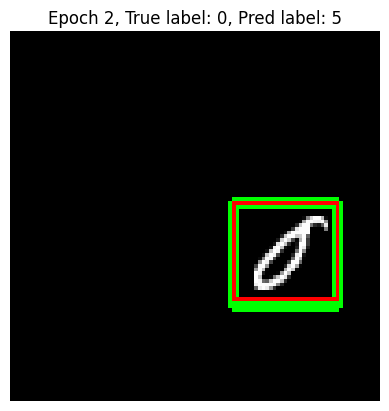

------------- Epoch 3 -------------


Epoch 3/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 103.40it/s, Loss=2.83]


Train stage: clf_loss:  1.554  reg_loss:  0.038  total_loss:  3.502  accuracy:  0.449  iou:  0.879
Valid stage: clf_loss:  1.404  reg_loss:  0.040  total_loss:  2.809  accuracy:  0.507  iou:  0.872
-----------------------------------



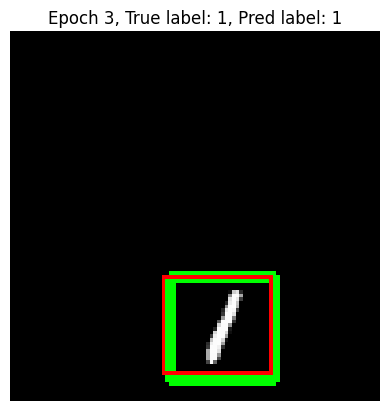

------------- Epoch 4 -------------


Epoch 4/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 104.38it/s, Loss=1.72]


Train stage: clf_loss:  1.325  reg_loss:  0.037  total_loss:  2.475  accuracy:  0.541  iou:  0.879
Valid stage: clf_loss:  1.206  reg_loss:  0.033  total_loss:  2.059  accuracy:  0.594  iou:  0.879
-----------------------------------



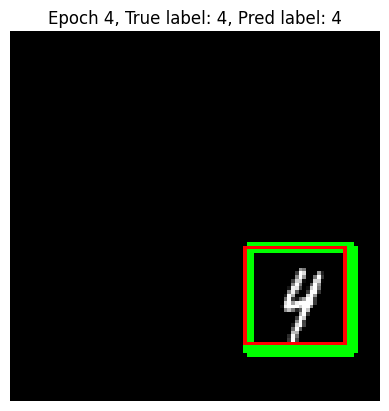

------------- Epoch 5 -------------


Epoch 5/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 100.12it/s, Loss=1.79] 


Train stage: clf_loss:  1.165  reg_loss:  0.039  total_loss:  1.956  accuracy:  0.604  iou:  0.877
Valid stage: clf_loss:  1.083  reg_loss:  0.030  total_loss:  1.741  accuracy:  0.636  iou:  0.890
-----------------------------------



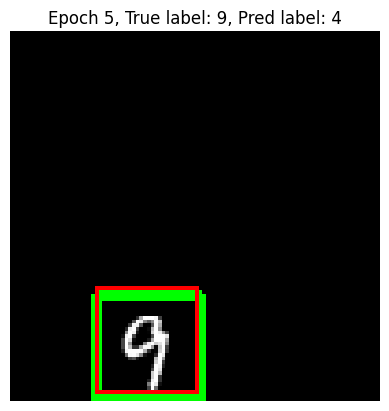

------------- Epoch 6 -------------


Epoch 6/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 104.87it/s, Loss=1.57] 


Train stage: clf_loss:  1.065  reg_loss:  0.029  total_loss:  1.681  accuracy:  0.642  iou:  0.891
Valid stage: clf_loss:  1.007  reg_loss:  0.020  total_loss:  1.536  accuracy:  0.663  iou:  0.908
-----------------------------------



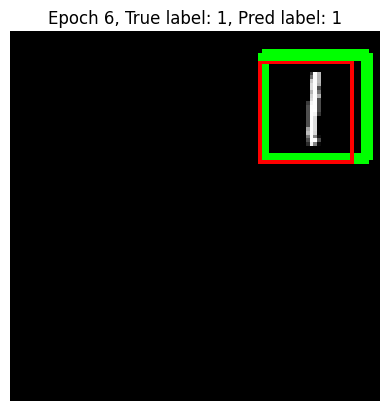

------------- Epoch 7 -------------


Epoch 7/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 99.47it/s, Loss=1.37]  


Train stage: clf_loss:  1.005  reg_loss:  0.027  total_loss:  1.530  accuracy:  0.664  iou:  0.895
Valid stage: clf_loss:  0.934  reg_loss:  0.024  total_loss:  1.380  accuracy:  0.689  iou:  0.901
-----------------------------------



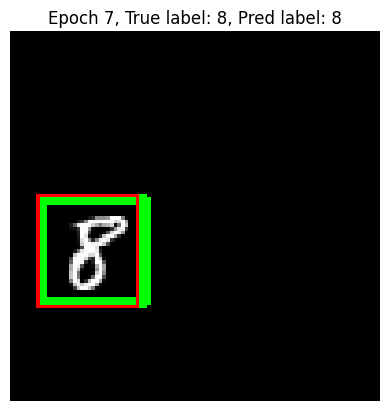

------------- Epoch 8 -------------


Epoch 8/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 107.37it/s, Loss=1.02] 


Train stage: clf_loss:  0.959  reg_loss:  0.026  total_loss:  1.433  accuracy:  0.678  iou:  0.898
Valid stage: clf_loss:  0.895  reg_loss:  0.030  total_loss:  1.294  accuracy:  0.707  iou:  0.892
-----------------------------------



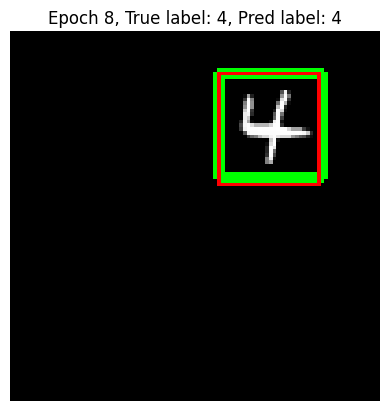

------------- Epoch 9 -------------


Epoch 9/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 105.00it/s, Loss=1.18] 


Train stage: clf_loss:  0.921  reg_loss:  0.026  total_loss:  1.346  accuracy:  0.694  iou:  0.897
Valid stage: clf_loss:  0.861  reg_loss:  0.024  total_loss:  1.227  accuracy:  0.714  iou:  0.901
-----------------------------------



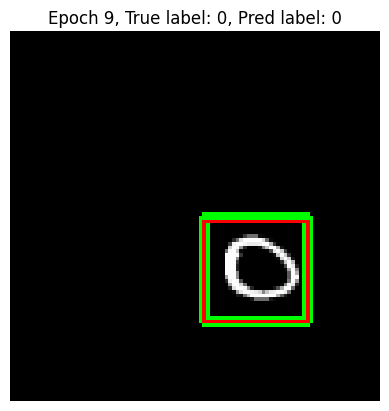

------------- Epoch 10 -------------


Epoch 10/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 102.92it/s, Loss=1.12] 


Train stage: clf_loss:  0.881  reg_loss:  0.021  total_loss:  1.263  accuracy:  0.706  iou:  0.906
Valid stage: clf_loss:  0.817  reg_loss:  0.026  total_loss:  1.136  accuracy:  0.735  iou:  0.893
-----------------------------------



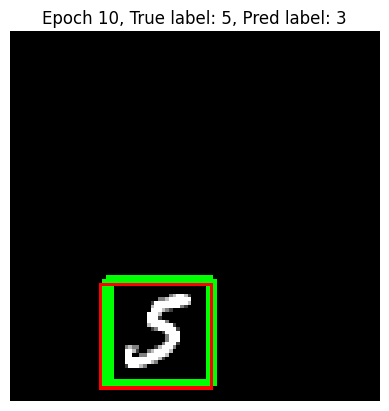

------------- Epoch 11 -------------


Epoch 11/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 108.69it/s, Loss=1.17] 


Train stage: clf_loss:  0.854  reg_loss:  0.019  total_loss:  1.203  accuracy:  0.717  iou:  0.910
Valid stage: clf_loss:  0.791  reg_loss:  0.016  total_loss:  1.078  accuracy:  0.741  iou:  0.914
-----------------------------------



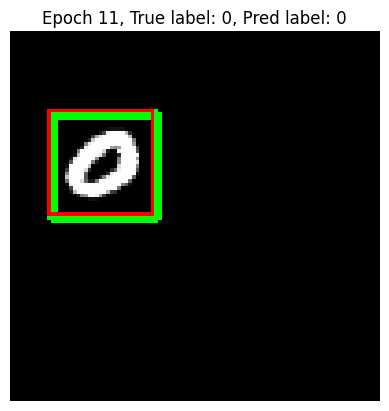

------------- Epoch 12 -------------


Epoch 12/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 99.24it/s, Loss=1.33]  


Train stage: clf_loss:  0.811  reg_loss:  0.020  total_loss:  1.123  accuracy:  0.731  iou:  0.907
Valid stage: clf_loss:  0.794  reg_loss:  0.018  total_loss:  1.095  accuracy:  0.735  iou:  0.911
-----------------------------------



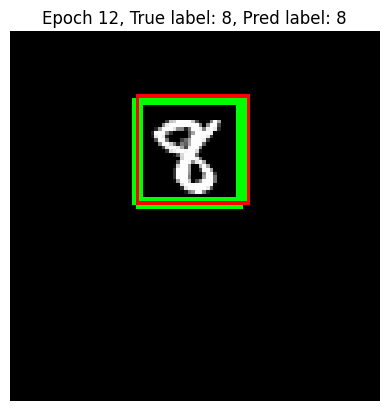

------------- Epoch 13 -------------


Epoch 13/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 100.59it/s, Loss=1.08] 


Train stage: clf_loss:  0.779  reg_loss:  0.021  total_loss:  1.063  accuracy:  0.743  iou:  0.906
Valid stage: clf_loss:  0.734  reg_loss:  0.015  total_loss:  0.979  accuracy:  0.759  iou:  0.919
-----------------------------------



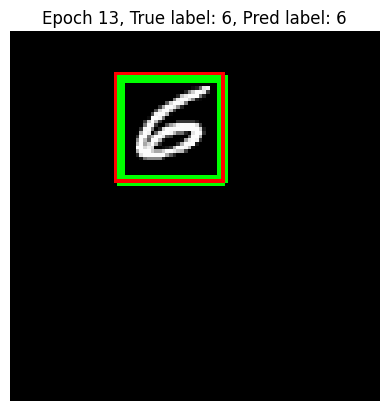

------------- Epoch 14 -------------


Epoch 14/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 106.87it/s, Loss=0.83] 


Train stage: clf_loss:  0.743  reg_loss:  0.020  total_loss:  0.994  accuracy:  0.758  iou:  0.908
Valid stage: clf_loss:  0.670  reg_loss:  0.020  total_loss:  0.879  accuracy:  0.780  iou:  0.906
-----------------------------------



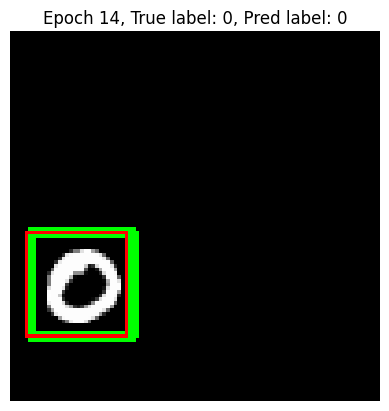

------------- Epoch 15 -------------


Epoch 15/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 107.60it/s, Loss=0.708]


Train stage: clf_loss:  0.684  reg_loss:  0.019  total_loss:  0.894  accuracy:  0.777  iou:  0.909
Valid stage: clf_loss:  0.616  reg_loss:  0.032  total_loss:  0.799  accuracy:  0.805  iou:  0.877
-----------------------------------



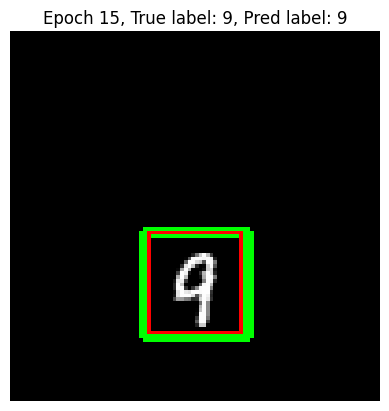

------------- Epoch 16 -------------


Epoch 16/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 100.34it/s, Loss=0.61] 


Train stage: clf_loss:  0.611  reg_loss:  0.018  total_loss:  0.774  accuracy:  0.803  iou:  0.912
Valid stage: clf_loss:  0.543  reg_loss:  0.017  total_loss:  0.676  accuracy:  0.824  iou:  0.914
-----------------------------------



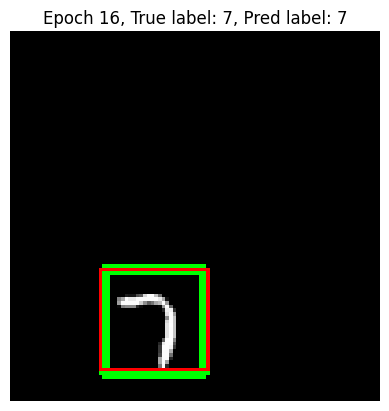

------------- Epoch 17 -------------


Epoch 17/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 105.34it/s, Loss=0.347]


Train stage: clf_loss:  0.536  reg_loss:  0.017  total_loss:  0.661  accuracy:  0.828  iou:  0.914
Valid stage: clf_loss:  0.479  reg_loss:  0.019  total_loss:  0.586  accuracy:  0.848  iou:  0.910
-----------------------------------



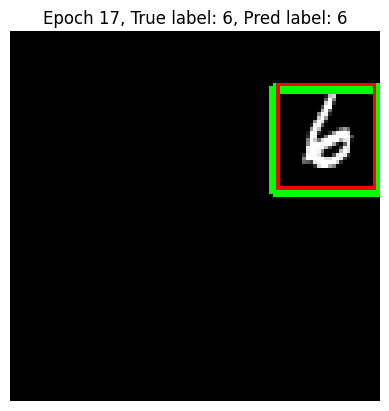

------------- Epoch 18 -------------


Epoch 18/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 100.76it/s, Loss=0.223]


Train stage: clf_loss:  0.478  reg_loss:  0.016  total_loss:  0.576  accuracy:  0.848  iou:  0.916
Valid stage: clf_loss:  0.434  reg_loss:  0.014  total_loss:  0.518  accuracy:  0.865  iou:  0.920
-----------------------------------



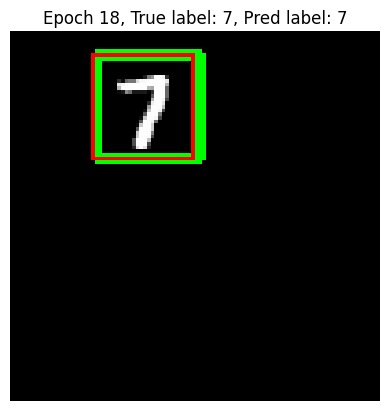

------------- Epoch 19 -------------


Epoch 19/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 99.98it/s, Loss=0.406] 


Train stage: clf_loss:  0.433  reg_loss:  0.015  total_loss:  0.514  accuracy:  0.864  iou:  0.919
Valid stage: clf_loss:  0.389  reg_loss:  0.011  total_loss:  0.454  accuracy:  0.881  iou:  0.929
-----------------------------------



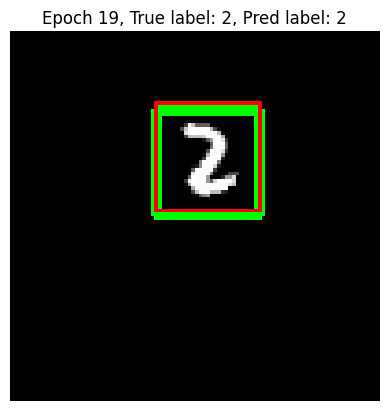

------------- Epoch 20 -------------


Epoch 20/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 101.37it/s, Loss=0.272]


Train stage: clf_loss:  0.396  reg_loss:  0.015  total_loss:  0.465  accuracy:  0.877  iou:  0.918
Valid stage: clf_loss:  0.352  reg_loss:  0.012  total_loss:  0.408  accuracy:  0.891  iou:  0.928
-----------------------------------



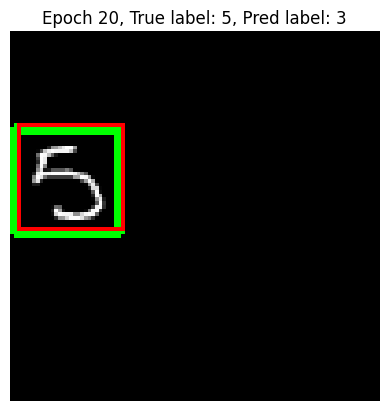

------------- Epoch 21 -------------


Epoch 21/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 101.79it/s, Loss=0.168]


Train stage: clf_loss:  0.369  reg_loss:  0.015  total_loss:  0.429  accuracy:  0.886  iou:  0.920
Valid stage: clf_loss:  0.325  reg_loss:  0.013  total_loss:  0.372  accuracy:  0.904  iou:  0.926
-----------------------------------



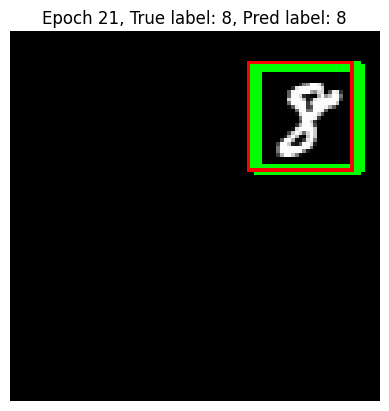

------------- Epoch 22 -------------


Epoch 22/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 102.42it/s, Loss=0.241]


Train stage: clf_loss:  0.347  reg_loss:  0.015  total_loss:  0.401  accuracy:  0.894  iou:  0.918
Valid stage: clf_loss:  0.311  reg_loss:  0.011  total_loss:  0.356  accuracy:  0.904  iou:  0.928
-----------------------------------



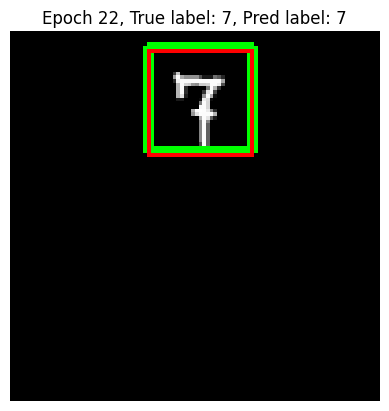

------------- Epoch 23 -------------


Epoch 23/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 104.22it/s, Loss=0.11]  


Train stage: clf_loss:  0.328  reg_loss:  0.014  total_loss:  0.377  accuracy:  0.899  iou:  0.921
Valid stage: clf_loss:  0.307  reg_loss:  0.021  total_loss:  0.361  accuracy:  0.905  iou:  0.906
-----------------------------------



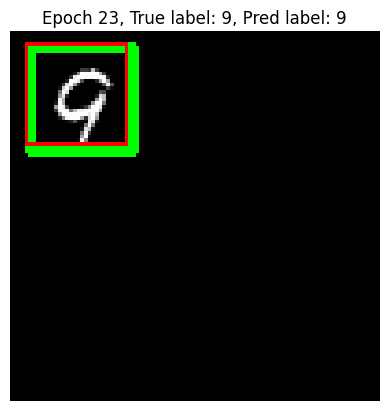

------------- Epoch 24 -------------


Epoch 24/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 98.84it/s, Loss=0.244] 


Train stage: clf_loss:  0.313  reg_loss:  0.015  total_loss:  0.359  accuracy:  0.905  iou:  0.919
Valid stage: clf_loss:  0.284  reg_loss:  0.015  total_loss:  0.327  accuracy:  0.913  iou:  0.918
-----------------------------------



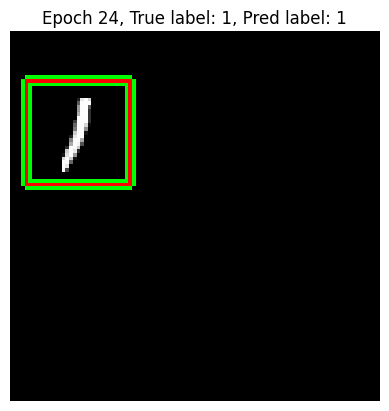

------------- Epoch 25 -------------


Epoch 25/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 99.04it/s, Loss=0.16]   


Train stage: clf_loss:  0.301  reg_loss:  0.014  total_loss:  0.343  accuracy:  0.909  iou:  0.921
Valid stage: clf_loss:  0.276  reg_loss:  0.013  total_loss:  0.316  accuracy:  0.913  iou:  0.927
-----------------------------------



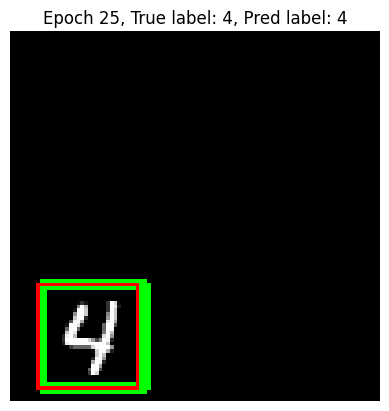

------------- Epoch 26 -------------


Epoch 26/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 97.01it/s, Loss=0.128]  


Train stage: clf_loss:  0.288  reg_loss:  0.015  total_loss:  0.329  accuracy:  0.913  iou:  0.920
Valid stage: clf_loss:  0.259  reg_loss:  0.020  total_loss:  0.301  accuracy:  0.924  iou:  0.906
-----------------------------------



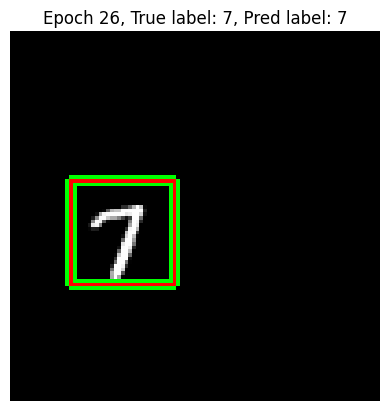

------------- Epoch 27 -------------


Epoch 27/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 108.49it/s, Loss=0.0716]


Train stage: clf_loss:  0.281  reg_loss:  0.014  total_loss:  0.320  accuracy:  0.915  iou:  0.921
Valid stage: clf_loss:  0.254  reg_loss:  0.012  total_loss:  0.289  accuracy:  0.923  iou:  0.926
-----------------------------------



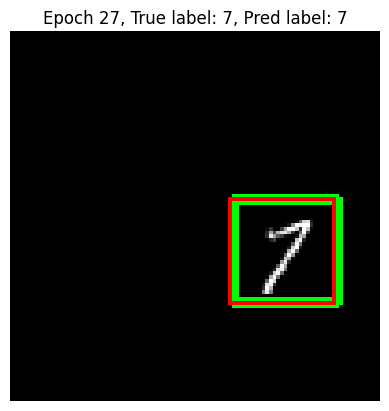

------------- Epoch 28 -------------


Epoch 28/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 101.20it/s, Loss=0.0864]


Train stage: clf_loss:  0.271  reg_loss:  0.014  total_loss:  0.307  accuracy:  0.918  iou:  0.921
Valid stage: clf_loss:  0.234  reg_loss:  0.013  total_loss:  0.266  accuracy:  0.928  iou:  0.922
-----------------------------------



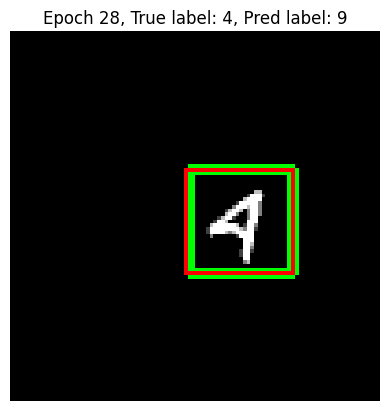

------------- Epoch 29 -------------


Epoch 29/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 99.73it/s, Loss=0.115]  


Train stage: clf_loss:  0.264  reg_loss:  0.014  total_loss:  0.299  accuracy:  0.919  iou:  0.921
Valid stage: clf_loss:  0.235  reg_loss:  0.011  total_loss:  0.265  accuracy:  0.928  iou:  0.929
-----------------------------------



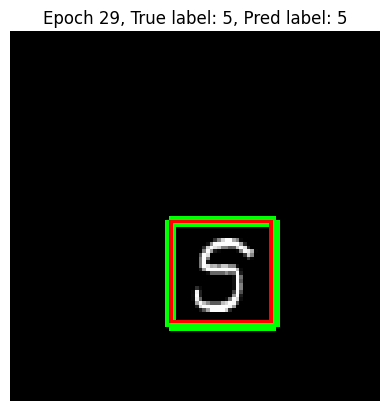

------------- Epoch 30 -------------


Epoch 30/30 [Test]: 100%|██████████| 79/79 [00:00<00:00, 100.33it/s, Loss=0.0754]


Train stage: clf_loss:  0.258  reg_loss:  0.015  total_loss:  0.293  accuracy:  0.923  iou:  0.920
Valid stage: clf_loss:  0.231  reg_loss:  0.018  total_loss:  0.267  accuracy:  0.933  iou:  0.911
-----------------------------------



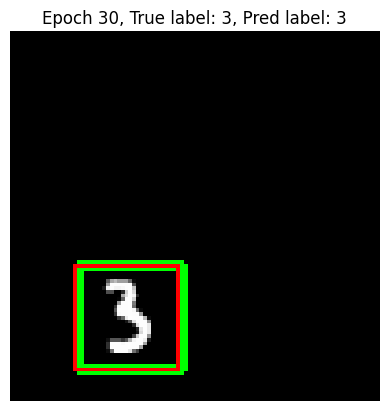

🏃 View run convnext_tiny_bs_128_lr_0.001 at: http://localhost:5000/#/experiments/802106284526614622/runs/f7ee53d320284ee182c0dbb868278ce6
🧪 View experiment at: http://localhost:5000/#/experiments/802106284526614622


In [178]:
logs = fit_with_mlflow(
    model=model,
    epochs=30,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
    augmentation=False,
    experiment_name="Localization",
)

Такой результат должен выводиться после каждой эпохи: 

<img src="aux/output.png">

In [179]:
print(*logs.keys(), sep="\n")

epoch_train_clf_loss
epoch_valid_clf_loss
epoch_train_box_loss
epoch_valid_box_loss
epoch_train_total_loss
epoch_valid_total_loss
epoch_train_accuracy
epoch_valid_accuracy
epoch_train_iou
epoch_valid_iou


In [184]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np


def plot_history(history, grid=True, suptitle="Model History"):
    fig = plt.figure(figsize=(16, 20), dpi=300)
    fig.suptitle(suptitle, fontsize=24, fontweight="bold", y=0.92)

    gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.4, wspace=0.3)

    # 1 ряд: CrossEntropy и L1 loss
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    ax0.plot(history["epoch_train_clf_loss"], label="train loss")
    ax0.plot(history["epoch_valid_clf_loss"], label="valid loss")
    ax0.set_title(
        f'CrossEntropy loss (epoch {len(history["epoch_train_clf_loss"])})',
        fontsize=16,
    )
    ax0.grid(grid)
    ax0.set_ylim(
        0, max(history["epoch_train_clf_loss"] + history["epoch_valid_clf_loss"]) + 0.1
    )
    ax0.legend(fontsize=14)
    ax0.set_xlabel("Epoch", fontsize=14)
    ax0.set_ylabel("Loss", fontsize=14)

    ax1.plot(history["epoch_train_box_loss"], label="train loss")
    ax1.plot(history["epoch_valid_box_loss"], label="valid loss")
    ax1.set_title(
        f'L1 loss (epoch {len(history["epoch_train_box_loss"])})', fontsize=16
    )
    ax1.grid(grid)
    ax1.set_ylim(0, max(history["epoch_valid_box_loss"]) + 0.1)
    ax1.legend(fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=14)
    ax1.set_ylabel("Loss", fontsize=14)

    # 2 ряд: Total loss на всю ширину
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(history["epoch_train_total_loss"], label="train total loss")
    ax2.plot(history["epoch_valid_total_loss"], label="valid total loss")
    ax2.set_title(
        f'Total loss (epoch {len(history["epoch_train_total_loss"])})', fontsize=16
    )
    ax2.grid(grid)
    ax2.set_ylim(
        0,
        max(history["epoch_train_total_loss"] + history["epoch_valid_total_loss"])
        + 0.1,
    )
    ax2.legend(fontsize=14)
    ax2.set_xlabel("Epoch", fontsize=14)
    ax2.set_ylabel("Loss", fontsize=14)

    # 3 ряд: Accuracy и IOU
    ax3 = fig.add_subplot(gs[2, 0])
    ax4 = fig.add_subplot(gs[2, 1])

    ax3.plot(history["epoch_train_accuracy"], label="train acc")
    ax3.plot(history["epoch_valid_accuracy"], label="valid acc")
    ax3.set_title(
        f'Accuracy (epoch {len(history["epoch_train_accuracy"])})', fontsize=16
    )
    ax3.grid(grid)
    ax3.set_ylim(min(history["epoch_train_accuracy"]) - 0.05, 1)
    ax3.legend(fontsize=14)
    ax3.set_xlabel("Epoch", fontsize=14)
    ax3.set_ylabel("Accuracy", fontsize=14)

    ax4.plot(history["epoch_train_iou"], label="train iou")
    ax4.plot(history["epoch_valid_iou"], label="valid iou")
    ax4.set_title(f'IOU (epoch {len(history["epoch_train_iou"])})', fontsize=16)
    ax4.grid(grid)
    ax4.set_ylim(min(history["epoch_train_iou"]) - 0.05, 1)
    ax4.legend(fontsize=14)
    ax4.set_xlabel("Epoch", fontsize=14)
    ax4.set_ylabel("IOU", fontsize=14)
    plt.tight_layout()
    plt.show()
    return fig


# rect=[0, 0, 1, 0.8]

/tmp/ipykernel_60079/4163088834.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


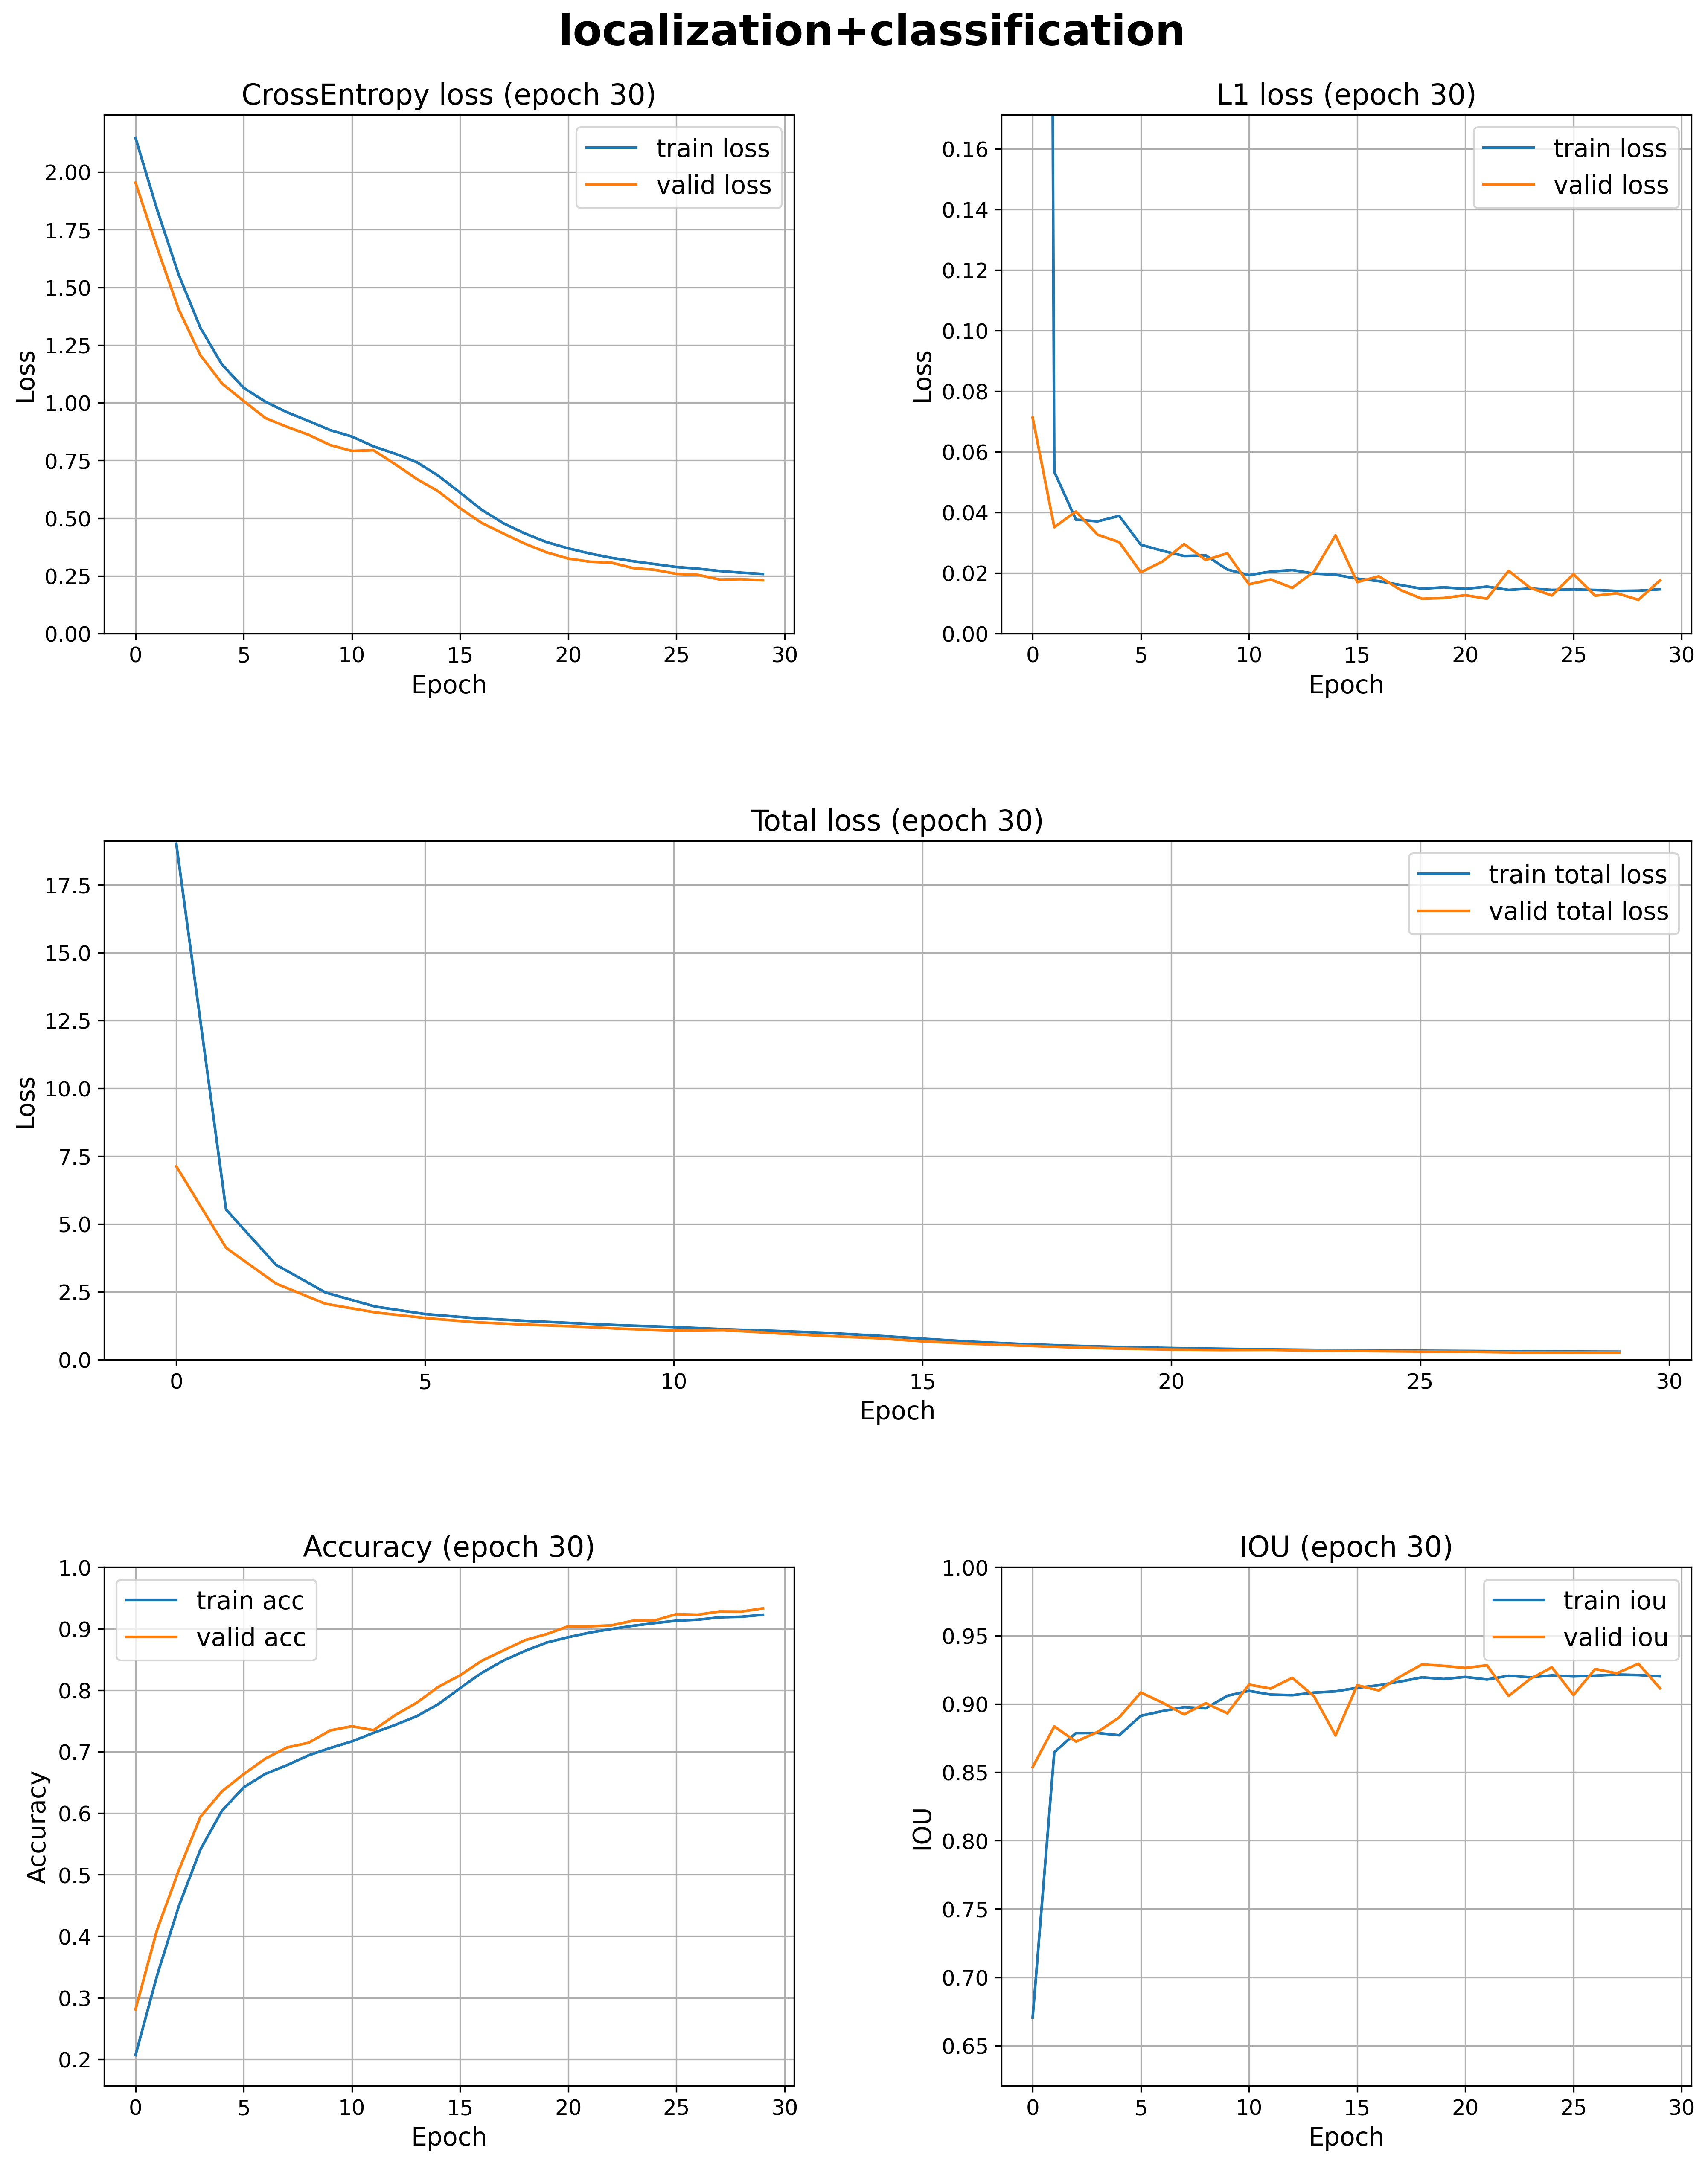

In [185]:
fig = plot_history(logs, suptitle="localization+classification")

In [186]:
fig.savefig("results/good_run_7_simple_model_the_best.png")

Визуализируй все лоссы и метрики, которые были собраны в процессе обучения. Пример диаграммы ниже. 

<img src="aux/training_curves.png">

